<a href="https://colab.research.google.com/github/carbotton/tdl_tarea_1/blob/eda_preproc_data-aug/Tarea_1_letra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema así como las técnicas y herramientas que quieran usar. Recomendamos usar Colab por simplicidad, pero pueden implementarlo en sus máquinas si así lo prefieren. La única limitante es que esperamos que la entrega sea en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar models pre-entrenados (cada modelo debe ser implementado desde cero)
- Se requiere que utilicen al menos 2 técnicas de **regularización** (Dropout, BatchNorm, Data Augmentation, etc.)
- Se requiere realizar un **análisis de los datos**, que incluya el balanceo de clases y tomar decisiones en base al análisis realizado.
- Las decisiones tomadas sobre el preprocesamiento de las imágenes (transforms, augmentation, etc.) deben ser resultado de la exploración del dataset y estar propiamente justificadas (una sección de exploración en el notebook con comentarios es suficiente).

**Reporte**

En particular, les pedimos que reporten: accuracy, precision, recall y f1.
También se espera poder observar la evolución del modelo (en los datos de train y validación) a medida que se entrena (logs, gráficas, etc).

**Evidencia de Experimentos**

Además, deben presentar evidencia de correr experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:
- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

# Lo que hicimos...

Empezamos probando LeNet. Sabiamos que el resultado no iba a ser el mejor pero quisimos probar hasta donde podiamos llegar haciendole algunas modificaciones.

Luego de esto decidimos utilizar DenseNet.
Probamos correrla con su arquitectura original y los resultados fueron mucho mejores, notando grandes diferencias simplemente modificando batch_size e image_size

# Librerias y constantes

In [39]:
!pip install torchinfo

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode

from torchinfo import summary

import os
from pathlib import Path

from utils import (
    train,
    evaluate,
    model_classification_report,
    show_tensor_image,
    show_tensor_images,
    plot_training,
    EarlyStopping,
    print_log,
    plot_training,
)

In [41]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [42]:
import sys
import os

# Configurar límite de memoria MPS para evitar errores de memoria
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


In [43]:
BATCH_SIZE = 32  # tamaño del batch reducido para evitar problemas de memoria

# Exploracion de datos

## Carga de datos

In [44]:
DATA_DIR = Path("data")

# cargamos train y lo dividimos en train y val
imagenette_full_train = datasets.Imagenette(
    DATA_DIR, split="train", download=True
)

In [45]:
name_classes = imagenette_full_train.classes # no puedo usar imagenette_train_dataset.classes porque es un subset (surge de haber hecho el random split, no tengo mas atributos de clase ahi
NUM_CLASES = len(name_classes)

print(f"Clases: {name_classes}")

Clases: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]


## Numero de clases y cantidad de imagenes por clase

Todas tienen cantidades similares de imágenes.

Entre la clase que menos tiene y la que más, hay una diferencia de 135 imagenes.

In [46]:
root_dir = "data/imagenette2/train"
classes = os.listdir(root_dir)

class_counts = {}
for cls in classes:
    n_images = len(os.listdir(os.path.join(root_dir, cls)))
    class_counts[cls] = n_images

# Encontrar la clase con menos y más imágenes
min_class = min(class_counts, key=class_counts.get)
max_class = max(class_counts, key=class_counts.get)

print(f"\nClase con MENOS imágenes: {min_class} ({class_counts[min_class]} imágenes)")
print(f"Clase con MÁS imágenes:  {max_class} ({class_counts[max_class]} imágenes)")
print(f"\nLa clase {max_class} tiene {((class_counts[max_class]-class_counts[min_class])/class_counts[max_class])*100:.1f}% más de imágenes que la clase {min_class}")



Clase con MENOS imágenes: n03000684 (858 imágenes)
Clase con MÁS imágenes:  n02979186 (993 imágenes)

La clase n02979186 tiene 13.6% más de imágenes que la clase n03000684


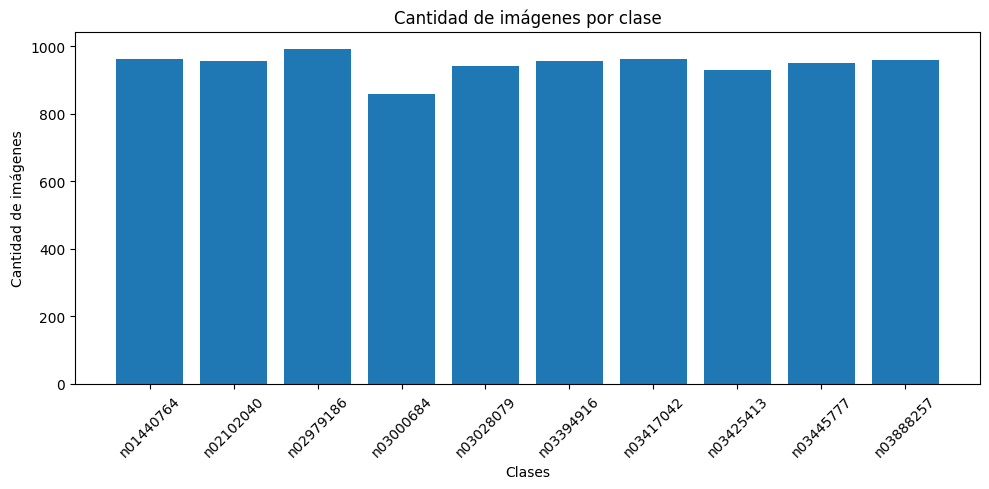

In [47]:
import matplotlib.pyplot as plt

# Ordenar clases para que el gráfico quede prolijo
sorted_classes = sorted(class_counts.keys())
sorted_counts = [class_counts[cls] for cls in sorted_classes]

plt.figure(figsize=(10, 5))
plt.bar(sorted_classes, sorted_counts)
plt.xticks(rotation=45)
plt.xlabel("Clases")
plt.ylabel("Cantidad de imágenes")
plt.title("Cantidad de imágenes por clase")
plt.tight_layout()
plt.show()


## Ver selección random de imágenes

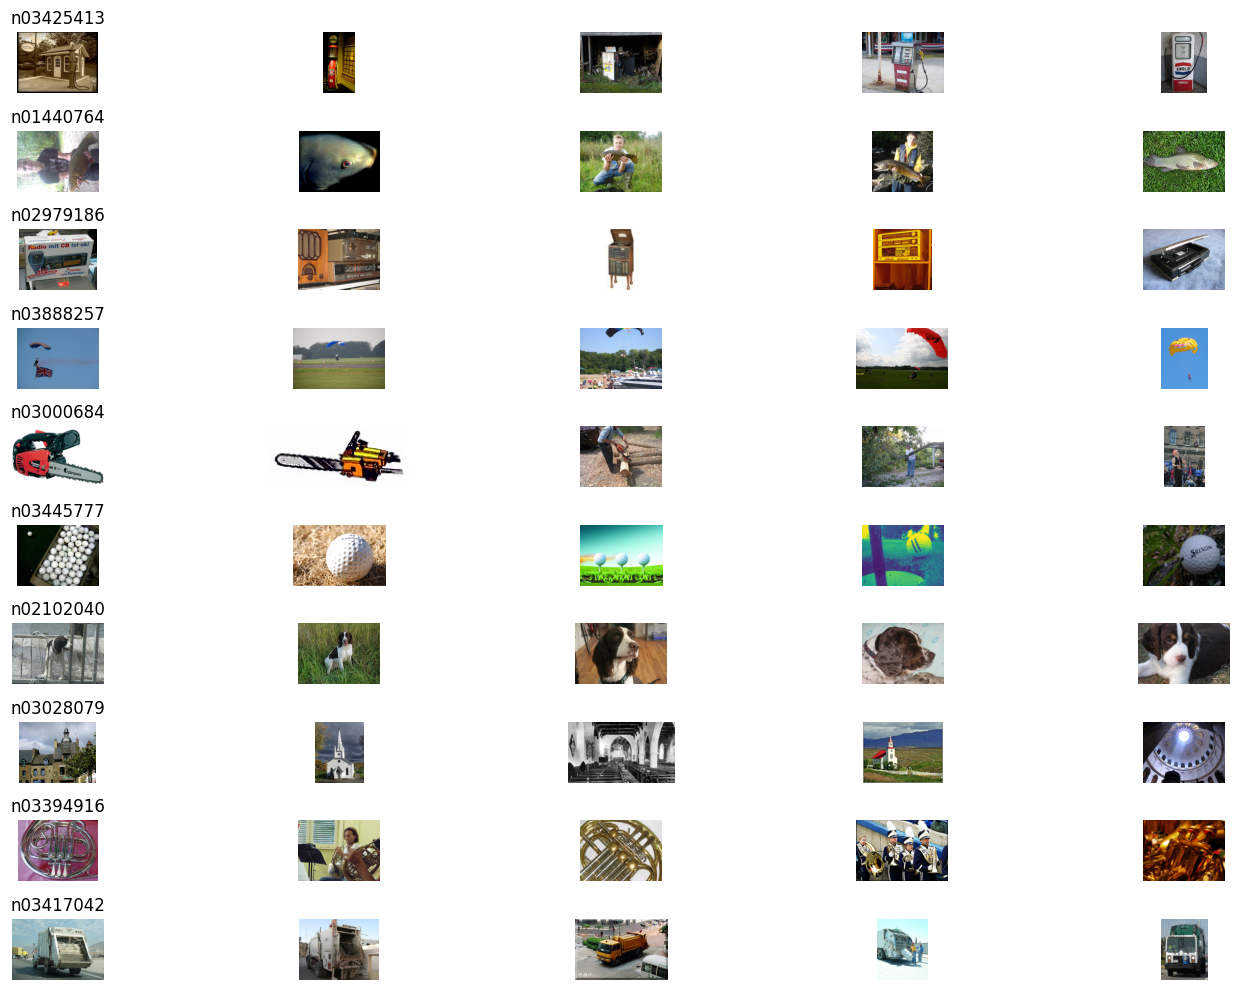

In [48]:
import random
import matplotlib.image as mpimg

n_samples = 5
fig, axs = plt.subplots(len(classes), n_samples, figsize=(15, 10))

for i, cls in enumerate(classes):
    img_files = os.listdir(os.path.join(root_dir, cls))
    for j in range(n_samples):
        img_path = os.path.join(root_dir, cls, random.choice(img_files))
        img = mpimg.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis("off")
        if j == 0:
            axs[i, j].set_title(cls)
plt.tight_layout()
plt.show()


## Ver tamaños de imágenes

Se puede observar que el tamaño de las imágenes difiere mucho entre una y otra.

In [49]:
from PIL import Image

sizes = []
for cls in classes:
    img_files = os.listdir(os.path.join(root_dir, cls))
    for img_file in img_files[:50]:  # muestra
        img_path = os.path.join(root_dir, cls, img_file)
        with Image.open(img_path) as img:
            sizes.append(img.size)  # (ancho, alto)

size_counts = {}
for size in sizes:
    if size not in size_counts:
        size_counts[size] = 0
    size_counts[size] += 1

# Encontrar el tamaño más y menos común
most_common_size = None
most_common_count = -1
least_common_size = None
least_common_count = float('inf')

for size, count in size_counts.items():
    if count > most_common_count:
        most_common_size = size
        most_common_count = count
    if count < least_common_count:
        least_common_size = size
        least_common_count = count

print(f"\nTotal de tamaños diferentes encontrados: {len(size_counts)}")
print(f"Tamaño MÁS común: {most_common_size} (aparece {most_common_count} veces)")
print(f"Tamaño MENOS común: {least_common_size} (aparece {least_common_count} veces)")



Total de tamaños diferentes encontrados: 226
Tamaño MÁS común: (500, 375) (aparece 112 veces)
Tamaño MENOS común: (470, 500) (aparece 1 veces)


## Buscar duplicados

In [50]:
import hashlib

def md5(fname):
    with open(fname, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

hashes = {}
duplicates = []
for cls in classes:
    for img_file in os.listdir(os.path.join(root_dir, cls)):
        path = os.path.join(root_dir, cls, img_file)
        h = md5(path)
        if h in hashes:
            duplicates.append(path)
        else:
            hashes[h] = path
print(f"Encontradas {len(duplicates)} imágenes duplicadas.")


Encontradas 0 imágenes duplicadas.


## Conclusión de la exploracion de datos

Del análisis anterior podemos observar que las clases se encuentran balanceadas, ya que cada una posee un número similar de imágenes. Además, verificamos que no existen duplicados, por lo que no es necesario eliminar ninguna imagen. Finalmente, notamos que las imágenes presentan distintas dimensiones, por lo que es necesario aplicar un proceso de resize para garantizar la consistencia del conjunto de datos.

# LeNet

## Carga de datos con transforms para LeNet

**Transforms:**

Preprocessing -> train y val/test

Data augmentation -> solo train

In [51]:
DATA_DIR = Path("data")

# Wrapper para aplicar transformaciones
class TransforsmDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        image, label = self.subset[idx]
        return self.transform(image), label

def get_dataloaders(
    train_transf, test_transf, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
):
    """
    Función para obtener los dataloaders de entrenamiento, validación y test

    Args:
    - train_transf: transformaciones para el dataset de entrenaiento
    - test_transf: transformaciones para el dataset de test
    - batch_size: tamaño del batch
    - num_workers: número de workers para cargar los datos
    """

    # descargamos el dataset
    train_dataset = datasets.Imagenette(
        DATA_DIR, split="train", download=True, transform=None
    ) 
    test_dataset = datasets.Imagenette(
        DATA_DIR, split="val", download=False, transform=test_transf
    )

    # dividimos el dataset de entrenamiento en entrenamiento y validación
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, validation_dataset = random_split(
        train_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(SEED),  # fijamos la semilla
    )

    # aplicamos las transformaciones
    train_dataset = TransformDataset(train_dataset, train_transf)
    validation_dataset = TransformDataset(validation_dataset, test_transf)

    # creamos los dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    valid_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, valid_loader, test_loader

In [52]:
IMG_SIZE = 128  # Reducir tamaño de imagen para ahorrar memoria

In [53]:
train_dataset = train_dataset = datasets.Imagenette(
    DATA_DIR, split="train", download=False, transform=val_tfms_lenet
) 

# Stack todas las imágenes en un tensor
data = torch.stack([img for img, _ in train_dataset])
# Shape: (50000, 3, 32, 32)

# Calcula mean y std por canal
T_MEAN = data.mean(dim=[0, 2, 3])  # Promedia sobre samples, height, width
T_STD = data.std(dim=[0, 2, 3])

print(f"Mean: {T_MEAN}")
print(f"Std: {T_STD}")

Mean: tensor([-3.2832e-06, -6.8662e-06, -3.5193e-06])
Std: tensor([1.0000, 1.0000, 1.0000])


In [54]:
train_tfms_lenet = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])

val_tfms_lenet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])


## Regularization

Para saber si necesitamos dropout, entrenar una vez y ver si hay overfitting (val_acc=85% agregar ; val_acc=78% no hace falta)

### Data Augmentation
SOLO PARA TRAINING !!!!!!!!!

### Early stopping

Aplicado en training loop

### Dropout

Aplicado en training loop

## Arquitectura del modelo

In [55]:
class LeNet(nn.Module):
    def __init__(self, in_channels, num_classes, use_dropout=False, dropout_p=0.5):
        """
        LeNet clasica con opción de dropout
        """
        
        super(LeNet, self).__init__()

        self.use_dropout = use_dropout
        self.dropout_p = dropout_p
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.tanh = nn.Tanh()
        self.linear = nn.Linear(120, 84)
        self.output = nn.Linear(84, num_classes)
        self.flatten = nn.Flatten(start_dim=1)

        self.dropout = nn.Dropout(p=self.dropout_p) if self.use_dropout else nn.Identity()


    def forward(self, x):
        x = self.tanh(self.conv1(x))
        x = self.pool(x)
        x = self.tanh(self.conv2(x))
        x = self.pool(x)
        x = self.tanh(self.conv3(x))
        x = self.flatten(x)
        x = self.tanh(self.linear(x))
        x = self.dropout(x) # despues de la activacion
        x = self.output(x)
        return x


summary(LeNet(1, 10), input_size=(BATCH_SIZE, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [32, 10]                  --
├─Conv2d: 1-1                            [32, 6, 28, 28]           156
├─Tanh: 1-2                              [32, 6, 28, 28]           --
├─AvgPool2d: 1-3                         [32, 6, 14, 14]           --
├─Conv2d: 1-4                            [32, 16, 10, 10]          2,416
├─Tanh: 1-5                              [32, 16, 10, 10]          --
├─AvgPool2d: 1-6                         [32, 16, 5, 5]            --
├─Conv2d: 1-7                            [32, 120, 1, 1]           48,120
├─Tanh: 1-8                              [32, 120, 1, 1]           --
├─Flatten: 1-9                           [32, 120]                 --
├─Linear: 1-10                           [32, 84]                  10,164
├─Tanh: 1-11                             [32, 84]                  --
├─Identity: 1-12                         [32, 84]                  --
├─L

## Entrenamiento con optimizaciones de memoria


In [56]:
LR = 0.001
EPOCHS = 100
criterion = nn.CrossEntropyLoss().to(DEVICE)

In [57]:
letnet_model = LeNet(3,10).to(DEVICE)
optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

epoch_train_errors, epoch_val_errors = train(
    letnet_model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    DEVICE,
    do_early_stopping=True,
    patience=10,
    epochs=EPOCHS,
    log_fn=print_log,
    log_every=1,
)

NameError: name 'train_loader' is not defined

In [ ]:
plot_taining(epoch_train_errors, epoch_val_errors)

In [ ]:
model_classification_report(letnet_model, val_loader, DEVICE, NUM_CLASES)

## Weight & Biases

In [ ]:
import wandb

WANDB_TEAM_NAME = "mc-ort"
WANDB_PROJECT = "Tarea1_LeNet_2"
os.environ["WANDB_NOTEBOOK_NAME"] = "./Tarea_1_letra.ipynb"

wandb.login()

In [ ]:
sweep_config = {
    "name": "tarea_1_lenet_memory_optimized",
    "method": "random",
    "metric": {"name": "val_macro_f1", "goal": "maximize"},  # o "val_accuracy"
    "parameters": {
        # Optimizador y LR
        "optimizer": {"values": ["adam", "sgd"]},
        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 5e-3},
        "weight_decay": {"values": [0.0, 1e-4, 5e-4]},

        # Regularización en FC
        "dropout_p": {"values": [0.0, 0.2, 0.3]},

        # Data - Batch sizes más pequeños para evitar problemas de memoria
        "batch_size": {"values": [16, 32, 64]},

        # Early stopping
        "early_stop": {"values": [True, False]},
        "patience": {"values": [3, 5]},   

        # Entrenamiento                
        "label_smoothing": {"values": [0.0, 0.05]},
        
        # Parámetros de optimización de memoria
        "gradient_accumulation_steps": {"values": [2, 4, 8]},
    },
}

sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

In [ ]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss})


In [ ]:
import time 

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep con optimizaciones de memoria.
    """
    # inicializar un nuevo run
    print("[RUN] init", flush=True)
    wandb.init()

    print(f"[RUN] device = {DEVICE}", flush=True)
    
    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_optimizer = config.optimizer
    run_weight_decay = config.weight_decay
    run_dropout_p = config.dropout_p
    run_batch_size = config.batch_size
    run_early_stopping = config.early_stop
    run_patience = config.patience
    run_label_smoothing = config.label_smoothing
    run_gradient_accumulation = config.gradient_accumulation_steps

    # modelo
    if run_dropout_p == 0:
        model = LeNet(3,10).to(DEVICE)
    else:
        model = LeNet(3,10,True,run_dropout_p).to(DEVICE)

    # dataloaders con batch size del sweep
    train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, run_batch_size, NUM_WORKERS)

    # optimizer
    if run_optimizer == "adam":
      optimizer = optim.Adam(model.parameters(), lr=run_learning_rate, weight_decay=run_weight_decay)
    elif run_optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=run_learning_rate, momentum=0.9, nesterov=True, weight_decay=run_weight_decay)

    # criterion
    if run_label_smoothing == 0:
        criterion = nn.CrossEntropyLoss().to(DEVICE)
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=run_label_smoothing).to(DEVICE)

    def log_with_timing(epoch, train_loss, val_loss):
        if (epoch + 1) % 10 == 0:
            wandb.log({"epoch": epoch+1, "train_loss": train_loss, "val_loss": val_loss})
            print(f"[EPOCH {epoch+1}] train_loss={train_loss:.4f} val_loss={val_loss:.4f}", flush=True)         

    print("[RUN] starting train with memory optimization...", flush=True)
    
    # Usar función de entrenamiento optimizada para memoria
    train_with_memory_optimization(
        model, optimizer, criterion, train_loader, val_loader, 
        device=DEVICE, do_early_stopping=run_early_stopping, patience=run_patience,
        epochs=EPOCHS, log_fn=log_with_timing, log_every=1,
        gradient_accumulation_steps=run_gradient_accumulation
    )
    
    # guardo pesos temporalmente
    torch.save(model.state_dict(), "model.pth")
    wandb.save(f"model.pth")

    wandb.finish()

In [ ]:
print("DEVICE = ", DEVICE)

In [ ]:
wandb.agent(sweep_id, function=sweep_run, count=10) # corre sweep_run 10 veces

## Evaluación final tomando mejor modelo

In [ ]:
# ULTIMA CORRIDA
# Create sweep with ID: 2ff0um8y

api = wandb.Api()
sweep = api.sweep(f"{WANDB_TEAM_NAME}/{WANDB_PROJECT}/{sweep_id}")
best_run = sweep.best_run()

print(f"Best run {best_run.name} with {best_run.summary['val_loss']} {best_run.id}")

best_run.file("model.pth").download(replace=True)

print("\nBest run name:", best_run.name)
print("\nBest run id:", best_run.id)
print("\nBest run config:", best_run.config)
print("\nSUMMARY:",best_run.summary_metrics)

In [ ]:
# restauramos el modelo
letnet_model.load_state_dict(torch.load("model.pth"))

# Si bien en wandb entrenamos con label_smoothing, para hacer la verificacion con el conjunto de test preferimos ver realmente como le va sin penalizar salidas correctas con label_smoothing

# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(letnet_model, criterion, test_loader, DEVICE)  

print(f"Test Loss: {test_loss:.5f}")

In [ ]:
model_classification_report(letnet_model, test_loader, DEVICE, NUM_CLASES)

## Conclusión de los datos

# DenseNet


## Constantes

In [ ]:
IMG_SIZE = 128

## Arquitectura

In [ ]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        y = self.conv(self.relu(self.bn(x)))
        return torch.cat([x,y] , dim=1)

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.block = []
        for i in range(num_layers):
            self.block += [DenseLayer(in_channels + i * growth_rate, growth_rate)]
        self.denseBlock = nn.Sequential(*self.block)
        

    def forward(self, x):
       return self.denseBlock(x)

In [ ]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True) #optional
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x = self.conv(self.bn(x))
        x = self.conv(self.relu(self.bn(x))) #relu es opcional
        return self.pool(x)

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, num_layers = [6, 12, 24, 16], growth_rate=32, num_classes=10, dropout_p=0.0):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.num_layers = num_layers
        self.num_blocks = len(num_layers)

        # Capa inicial: se encarga de extraer características iniciales
        current_channels = 3
        self.convI = nn.Conv2d(current_channels, 2*growth_rate, kernel_size=3, padding=1)
        current_channels = 2*growth_rate
        self.poolI = nn.MaxPool2d(2, 2)
        self.bnI = nn.BatchNorm2d(current_channels)
        self.relu = nn.ReLU(True)

        dense_blocks = []
        # Bloques densos y capas de transición en nn.Sequential
        for i in range(self.num_blocks):
            current_layers = num_layers[i]
            dense_blocks += [DenseBlock(current_layers, current_channels, growth_rate)]
            current_channels += current_layers * growth_rate
            if i < self.num_blocks - 1:
                dense_blocks += [TransitionLayer(current_channels, current_channels // 2)]
                current_channels = current_channels // 2
        self.dense_blocks = nn.Sequential(*dense_blocks)

        # Capa de clasificación
        self.avgPool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten(start_dim=1)
        self.classifier = nn.Linear(current_channels, num_classes)
        

    def forward(self, x):
        x = self.relu(self.bnI(self.convI(x)))
        x = self.dense_blocks(x)
        x = self.avgPool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


# Ejemplo de uso
model = DenseNet(num_layers=[6, 12, 24, 16], growth_rate=32, num_classes=10)

summary(model, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE), depth=3)

## Carga de dataos con transforms

In [ ]:
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, BATCH_SIZE, NUM_WORKERS)

#### OJO QUE ACA TODAVIA TENEMOS LOS TRANSFORMS DE LENET

## Entrenamiento

In [ ]:
model = DenseNet(
    num_layers=[6, 12, 24, 16], growth_rate=12, num_classes=10
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

CRITERION = nn.CrossEntropyLoss().to(DEVICE)

train_errors_dn, val_errors_dn = train(
    model=model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=8,
    epochs=EPOCHS,
)

In [ ]:
plot_training(train_errors_dn, val_errors_dn)

In [ ]:
model_classification_report(model, test_loader, DEVICE, NUM_CLASES)

# DenseNet 2

## Constantes

In [ ]:
IMG_SIZE = 128 #128
BATCH_SIZE = 16 #64
LR = 0.001
EPOCHS = 100

## Carga de datos con transformers

In [ ]:
train_tfms_denseNet = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    # Transformaciones comunes:
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])

val_tfms_denseNet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])

In [ ]:
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_denseNet, val_tfms_denseNet, BATCH_SIZE, NUM_WORKERS)

## Entrenamiento

In [ ]:
model = DenseNet(
    num_layers=[6, 12, 24, 16], growth_rate=12, num_classes=10
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

CRITERION = nn.CrossEntropyLoss().to(DEVICE)

import time
start = time.time()

train_errors_dn, val_errors_dn = train(
    model=model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=8,
    epochs=EPOCHS,
)

end = time.time()

print(f"Tiempo de ejecución: {end - start:.2f} segundos")

In [ ]:
plot_training(train_errors_dn, val_errors_dn)

In [ ]:
model_classification_report(model, test_loader, DEVICE, NUM_CLASES)

## Weight & Biases

## Conclusión de los datos

# Comparación final entre modelos

Usando best-model wandb de cada uno

* Tabla comparativa de métricas (accuracy, F1, etc.).
* Gráficas comparativas.
* Matrices de confusión lado a lado.
* Discusión de resultados.
* Graficas de wandb